# SMIB with AVR and PSS

In [1]:
import sys
sys.path.append('/home/jmmauricio/Documents/public/workspace/pydss/pydss')
from solvers import nr,ssa

In [2]:
import numpy as np 
import sympy as sym
from sympy.utilities.lambdify import lambdify, implemented_function
import scipy.signal as ctrl
import scipy.optimize as sopt
from ipywidgets import interact, interactive, widgets
from IPython.display import display
import matplotlib as mpl
import matplotlib.patches as patches
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
mpl.rc('animation', html='html5')
plt.style.use('presentation')
%matplotlib notebook
sin = sym.sin
cos = sym.cos

/home/jmmauricio/bin/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1041: UserWarning: Duplicate key in file "/home/jmmauricio/bin/anaconda3/lib/python3.5/site-packages/matplotlib/mpl-data/stylelib/presentation.mplstyle", line #10
  (fname, cnt))
/home/jmmauricio/bin/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1041: UserWarning: Duplicate key in file "/home/jmmauricio/bin/anaconda3/lib/python3.5/site-packages/matplotlib/mpl-data/stylelib/presentation.mplstyle", line #11
  (fname, cnt))
/home/jmmauricio/bin/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Trapezoidal

In [3]:
def run(t_0,x_0,y_0,u_0,f_eval,g_eval,F_x_eval,F_y_eval,G_x_eval,G_y_eval,pert,N_steps,Dt) :

    max_iter = 200
    t = t_0
    u_i = np.copy(u_0)
    N_x = x_0.shape[0]
    N_y = y_0.shape[0]
    X = np.zeros((N_steps,N_x));
    Y = np.zeros((N_steps,N_y));
    T = np.zeros((N_steps,1));

    for it in range(N_steps):
        x_i = np.copy(x_0)
        y_i = np.copy(y_0)
        


        u_i = pert(t,u_i)
        for iter in range(max_iter): 

            A_c_i = np.vstack([np.hstack([np.eye(N_x) - 0.5*Dt*F_x_eval(x_i,y_i,u_i), -0.5*Dt*F_y_eval(x_i,y_i,u_i)]),
                               np.hstack([                     G_x_eval(x_i,y_i,u_i),         G_y_eval(x_i,y_i,u_i)])])

            f_n_i = x_i - x_0 - 0.5*Dt*(f_eval(x_i,y_i,u_i)+f_eval(x_0,y_0,u_i))

            Dxy_i = -np.linalg.solve(A_c_i, np.vstack((f_n_i,g_eval(x_i,y_i,u_i))))

            x_i = x_i + Dxy_i[0:N_x]
            y_i = y_i + Dxy_i[N_x:(N_x+N_y)]

            if np.linalg.norm(Dxy_i,np.inf)<1.0e-8:
                break

        x_0 = x_i
        y_0 = y_i

        T[it,:] = t;
        X[it,:] = x_i[:,0];
        Y[it,:] = y_i[:,0];    
        t = it*Dt;
        
    return T,X,Y



## System with PSS

In [4]:
delta, omega, e1d, e1q = sym.symbols('delta omega e1d e1q')
i_d, i_q, v_d, v_q = sym.symbols('i_d i_q v_d v_q')
v_f, p_m = sym.symbols('v_f p_m')
X_d, X_q, X1d, X1q, X_l, R_a, T1d0, T1q0  = sym.symbols('X_d X_q X1d X1q X_l R_a T1d0 T1q0')
H, D = sym.symbols('H D')
V_t, theta_t, P_t, Q_t, V_inf, theta_inf = sym.symbols('V_t, theta_t, P_t, Q_t, V_inf, theta_inf')
B_t_inf, B_t0, G_t_inf, G_t0 = sym.symbols('B_t_inf, B_t0, G_t_inf, G_t0')
Omega_b, p_e = sym.symbols('Omega_b p_e')
v_c, K_a, T_r,V_ref, v_f_avr = sym.symbols('v_c, K_a, T_r,V_ref, v_f_avr')
x_pss, v_pss, T_pss_1, T_pss_2,K_stab = sym.symbols('x_pss, v_pss, T_pss_1, T_pss_2,K_stab ')
x_w, omega_w, T_w = sym.symbols('x_w, omega_w, T_w ')

In [5]:
N_x = 7
N_y = 12

ddelta = Omega_b * (omega - 1);
domega = 1/(2*H) * ( p_m - p_e - D * ( omega - 1)) ;
de1q   = 1/T1d0 * ( -e1q - (X_d - X1d ) * i_d + v_f);
de1d   = 1/T1q0 * ( -e1d + (X_q - X1q ) * i_q ) 
dv_c   = 1/T_r * ( V_t - v_c )
dx_pss = 1.0/T_pss_2*(omega_w - x_pss)
dx_w = 1.0/T_w*(omega - x_w)

g1 = v_q + R_a * i_q - e1q + (X1d - X_l)*i_d;
g2 = v_d + R_a * i_d - e1d - (X1q - X_l)*i_q;
g3 = p_e - (v_q + R_a*i_q)*i_q - (v_d + R_a*i_d)*i_d ;
g4 = v_d - V_t * sin(delta - theta_t);
g5 = v_q - V_t * cos(delta - theta_t);
g6 = v_d * i_d + v_q * i_q - P_t; 
g7 = v_q * i_d - v_d * i_q - Q_t;
g8 =  V_t**2*(G_t_inf+G_t0) - V_t*V_inf*(G_t_inf * cos(theta_t - theta_inf) + B_t_inf * sin(theta_t - theta_inf)) - P_t  
g9 = -V_t**2*(B_t_inf+B_t0) - V_t*V_inf*(G_t_inf * sin(theta_t - theta_inf) - B_t_inf * cos(theta_t - theta_inf)) - Q_t
g10 = K_a*(V_ref + v_pss - v_c) - v_f
g11 = v_pss - K_stab*(T_pss_1/T_pss_2*omega_w + (1.0-1.0/T_pss_2)*x_pss)
g12 = omega_w - (omega - x_w)

In [6]:
x = sym.Matrix([delta,omega,e1q,e1d,v_c,x_pss,x_w])
y = sym.Matrix([i_d,i_q,p_e,v_d,v_q,P_t,Q_t,theta_t,V_t,v_f,v_pss,omega_w])
u = sym.Matrix([p_m,V_ref,D,K_a,K_stab,B_t_inf,G_t0,V_inf])
f = sym.Matrix([ddelta, domega, de1q, de1d, dv_c,dx_pss,dx_w])
g = sym.Matrix([g1, g2, g3, g4, g5,g6, g7, g8,g9,g10,g11,g12])
h = sym.Matrix([P_t,Q_t,V_t])

F_x = f.jacobian(x)
F_y = f.jacobian(y)
G_x = g.jacobian(x)
G_y = g.jacobian(y)
F_u = f.jacobian(u)
G_u = g.jacobian(u)
H_x = f.jacobian(x)
H_u = g.jacobian(u)

In [7]:
X_d = 1.81
X1d  = 0.3
T1d0  = 8.0
X_q  = 1.76
X1q  = 0.65
T1q0  = 1.0 
R_a  =  0.003 
X_l  = 0.15  
H  = 3.5   
Omega_b = 2*np.pi*60

T_pss_1_val = 1.281
T_pss_2_val = 0.013


params_run = {
'X_d':  X_d,
'X1d':  X1d,
'T1d0': T1d0,
'X_q':  X_q,
'X1q':  X1q,
'T1q0': T1q0,
'R_a':  R_a,
'X_l': X_l,
'H':  H,
'Omega_b': Omega_b,
'B_t0':0.0, 
'G_t_inf':0.0,
'theta_inf':0.0,   
'T_r':0.05,  
'theta_inf':0.0,   
'T_r':0.05,  
'T_pss_1':T_pss_1_val,
'T_pss_2':T_pss_2_val,
'T_w':5.0
}

f_eval = lambdify((x,y,u), f.subs(params_run), "numpy")
g_eval = lambdify((x,y,u), g.subs(params_run), "numpy")

F_x_eval = lambdify((x,y,u), F_x.subs(params_run), "numpy")
F_y_eval = lambdify((x,y,u), F_y.subs(params_run), "numpy")
G_x_eval = lambdify((x,y,u), G_x.subs(params_run), "numpy")
G_y_eval = lambdify((x,y,u), G_y.subs(params_run), "numpy")

F_u_eval = lambdify((x,y,u), F_u.subs(params_run), "numpy")
G_u_eval = lambdify((x,y,u), G_u.subs(params_run), "numpy")
H_x_eval = lambdify((x,y,u), H_x.subs(params_run), "numpy")
H_u_eval = lambdify((x,y,u), H_u.subs(params_run), "numpy")

sys = [f_eval,g_eval,F_x_eval,F_y_eval,G_x_eval,G_y_eval,F_u_eval,G_u_eval,H_x_eval,H_u_eval]
lam_sym = f.col_join(g)
xi_sym = x.col_join(y)
Lam_f = F_x.row_join(F_y)
Lam_g = G_x.row_join(G_y)
Lam_sym = Lam_f.col_join(Lam_g)
 

lam = lambdify((xi_sym,u), lam_sym.subs(params_run), "numpy")
Lam = lambdify((xi_sym,u), Lam_sym.subs(params_run), "numpy")
h_eval = lambdify((xi_sym,u), h.subs(params_run), "numpy")

<IPython.core.display.Javascript object>


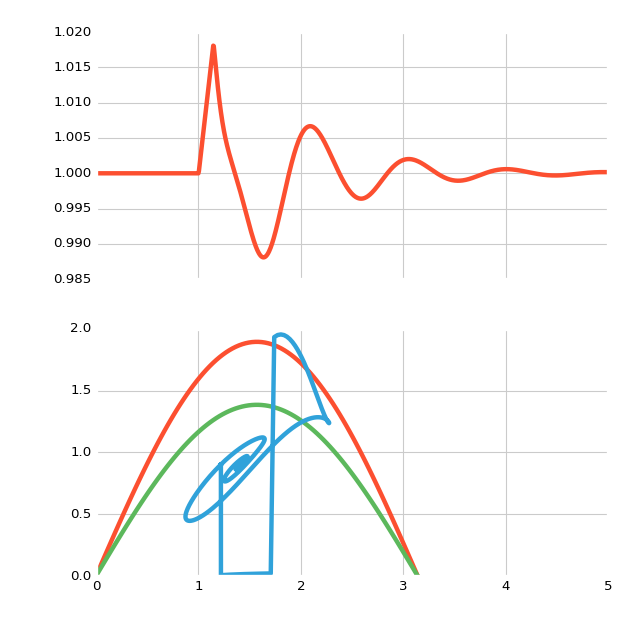

In [42]:
xi_0 = np.ones((19,1))
#xi_0[-6] = 0.9
#xi_0[-1] = 0.0
p_m = 0.9
V_ref = 1.0
D= 0.0
K_a = 200.0
K_stab = 0.5
V_inf = 0.90081
B_t_inf = -1.0/(0.15+1.0/(1.0/0.5+1.0/0.93))
u_val = np.array([p_m,V_ref,D,K_a,K_stab,B_t_inf,G_t0,V_inf])
xi_0 = nr(xi_0,u_val,lam,Lam)
t_0 = 0.0
u_0 = u_val
x_0,y_0 = xi_0[0:N_x],xi_0[N_x:(N_x+N_y)]

def pert(t,u):
    if t>1.0:
        Z_t_inf = -(0.15+0.0)
        #u_i[5] = 1.0/Z_t_inf
        #u[5] = 1.0/Z_t_inf        
        u[7] = 0.0
        #u_i[6] = (1.0/Z_t_inf)
    if t>1.15:
        Z_t_inf = -(0.15+0.5)
        #u_i[5] = 1.0/Z_t_inf
        u[5] = 1.0/Z_t_inf
        V_inf = 0.90081
        u[7] = V_inf
    return u
  
N_steps = 1000
Dt = 5.0e-3

T,X,Y = run(t_0,x_0,y_0,u_0,f_eval,g_eval,F_x_eval,F_y_eval,G_x_eval,G_y_eval,pert,N_steps,Dt) 



<IPython.core.display.Javascript object>


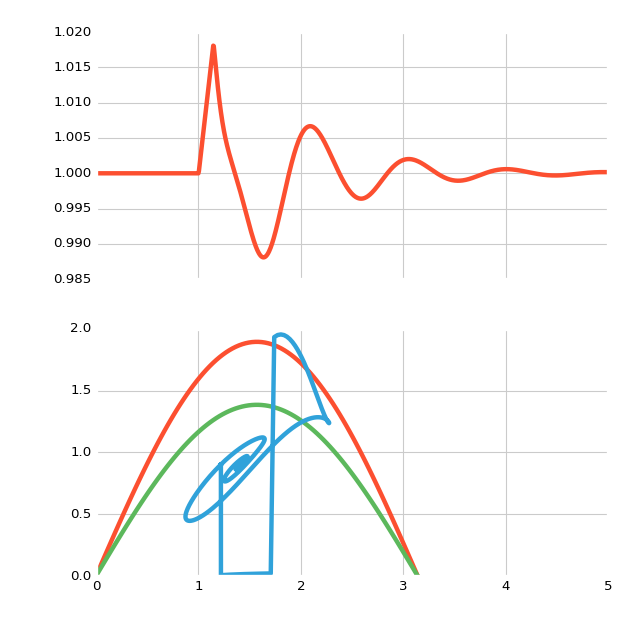

In [53]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8), sharex = True)
axes[0].plot(T, X[:,1])


delta_range = np.linspace(0.0,np.pi,100)
X_1 = (0.15+1.0/(1.0/0.5+1.0/0.93))
X_2 = (0.15+ 0.5)
axes[1].plot(delta_range, 1.0*0.9/X_1*np.sin(delta_range))
axes[1].plot(delta_range, 1.0*0.9/X_2*np.sin(delta_range))
axes[1].plot(X[:,0], Y[:,2])
